In [323]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/penugasan-oprec-dsai-2024/sample_submission.csv
/kaggle/input/penugasan-oprec-dsai-2024/Train.csv
/kaggle/input/penugasan-oprec-dsai-2024/Test.csv


# **Pendahuluan**

Pada kompetisi kali ini target outputnya berupa memprediksi gaji (salary) berdasarkan berbagai informasi mengenai pekerjaan, seperti tingkat pengalaman, tipe pekerjaan, lokasi perusahaan, dan faktor lainnya. Proses yang akan saya lakukan pertama-tama adalah melakukan Input, lalu Exploratory Data Analysis (EDA), Data Preprocessing, Feature Engineering, Model Training, Evaluasi Model, dan pengumpulan file submisi.

Pada **EDA** saya akan fokus untuk memvisuaslisasikan dataset yang diberikan guna untuk menentukan langkah selanjutnya dalam Data Preprocessing. Pada **Data Proprocessing** saya melakukan handling missing values, menambahkan features baru, mengelompokkan features yang memiliki kesamaan, merubah datatype categorical to numeric, dan memisahkan fitur dan target pada dataset. Pada tahap **Modelling** saya menggunakan model LightGBM dengan tambahan metode K-Fold Cross-Validation dan melakukan evaluate model prediction (menghasilkan nilai RMSE & R^2). Tahap terakhir adalah Mempersiapkan data testing untuk prediksi, menghasilkan prediksi salary untuk data testing menggunakan model yang telah dilatih, dan menyusun file submission sesuai dengan format.


# **A. Input**

Memasukkan segala libraries, path, dan data yang akan digunakan dalam pembentukan model.

In [324]:
# Import Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb
from category_encoders import TargetEncoder
import numpy as np

Penjelasan Libraries
1. Pandas
* Memuat, memproses dan menganalisis data dalam bentuk dataframe
* Membaca dan menulis file CSV
* Manipulasi data seperti filtering, grouping, dan handling missing values

2. seaborn
* Visualisasi data berbasis matplotlib dengan menbuat grafik statitiska (histogram, boxplot, heatmap, dll)
  
3. matplotlib.pyplot
* Visualisasi data (Line plot, bar plot, scatter plot, dll)

4. sklearn.model_selection (KFold & train_test_split)
* Melakukan validasi silang (cross-validation) untuk mengevaluasi performa model
* Membagi dataset menjadi data training dan testing

5. sklearn.metrics (Prediction)
* Mengukur rata-rata kesalahan kuadrat (RMSE)
* Mengukur seberapa baik model menjelaskan variabilitas data target (R^2_Score)

6. sklearn.preprocessing.OrdinalEncoder
* Mengonversi fitur kategori menjadi nilai numerik

7. lightgbm
* Pelatihan model

8. category_encoders.TargetEncoder
* Menangkap hubungan langsung antara fitur kategori dan target untuk meningkatkan akurasi model

9. numpy
* Mendukung operasi numerik


In [325]:
#Menonaktifkan warning 
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [326]:
# Paths
train_path = '/kaggle/input/penugasan-oprec-dsai-2024/Train.csv'
test_path = '/kaggle/input/penugasan-oprec-dsai-2024/Test.csv'
sample_submission_path = '/kaggle/input/penugasan-oprec-dsai-2024/sample_submission.csv'

# Load Data
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
sample_submission_df = pd.read_csv(sample_submission_path)

# **B. Exploratory Data Analysis**



In [327]:
# View the first 5 rows of the dataset
print("Train Dataset:") #Train
print(train_df.head())

print("\nTest Dataset:") #Test
print(test_df.head())

print("\nSample Submission Dataset:") #Sample Submission
print(sample_submission_df.head())

Train Dataset:
   id  work_year experience_level employment_type                  job_title  \
0   0     2024.0              NaN              FT              Data Engineer   
1   1     2024.0               SE              FT          Software Engineer   
2   2     2024.0              NaN              FT  Machine Learning Engineer   
3   3     2024.0              NaN             NaN              Data Engineer   
4   4     2024.0               SE              FT            Product Manager   

  salary_currency employee_residence  remote_ratio company_location  \
0             USD                 US           0.0               US   
1             USD                 US           2.0              NaN   
2             USD                 US           0.0               US   
3             USD                 US           0.0               US   
4             USD                 US           0.0               US   

  company_size  salary  
0            M  138000  
1            M  180000  
2 

Memeriksa dan meilhat 5 data teratas pada setiap dataset. Dapat dilihat bahwa target kita, yaitu salary berada pada train dataset. Hasil submisi kita nantinya, yang hanya berupa ID dan Salary semakin mirip dengan target pada train berarti akurasinya semakin tinggi.

In [328]:
# Display data types and column information for the train dataset
print("Train Dataset Info:")
print(train_df.info())

# Display data types and column information for the test dataset
print("\nTest Dataset Info:")
print(test_df.info())


Train Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35078 entries, 0 to 35077
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  35078 non-null  int64  
 1   work_year           28062 non-null  float64
 2   experience_level    28062 non-null  object 
 3   employment_type     28062 non-null  object 
 4   job_title           35078 non-null  object 
 5   salary_currency     35078 non-null  object 
 6   employee_residence  28062 non-null  object 
 7   remote_ratio        28062 non-null  float64
 8   company_location    28062 non-null  object 
 9   company_size        28062 non-null  object 
 10  salary              35078 non-null  int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 2.9+ MB
None

Test Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8770 entries, 0 to 8769
Data columns (total 10 columns):
 #   Column              Non-Null Count 

Melihat jenis datatype pada setiap dataset, dapat ditemukan bahwa ada dua tipe dataset yaitu categorical (object) dan numerical (int & float).

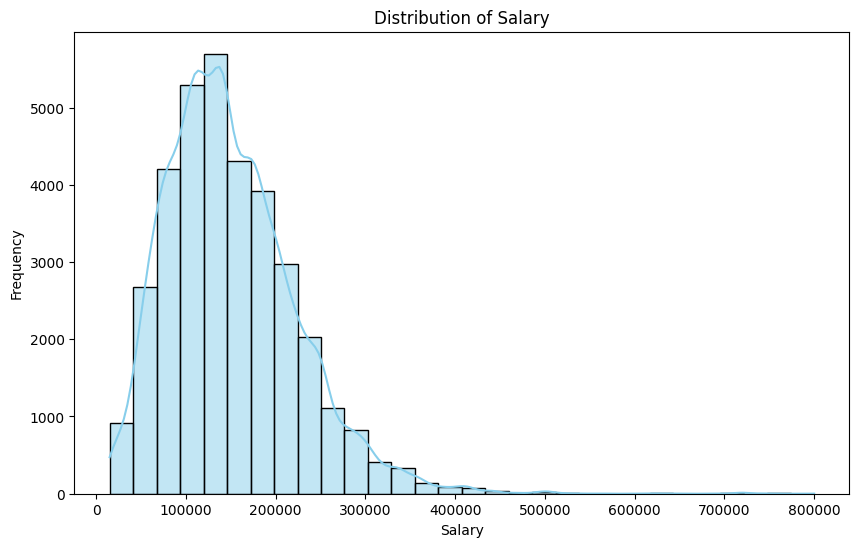

In [329]:
# 1. Visualisasi Distribusi Target Salary (Data Visualization)
plt.figure(figsize=(10, 6))
sns.histplot(train_df['salary'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Salary')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.show()

Pada visualisasi data ini, kita dapat melihat bahwa sebagian besar karyawan memiliki gaji (salary) di kisaran rata-rata, sementara hanya sebagian kecil karyawan yang memiliki salary sangat tinggi. Jadi kita dapat menyimpulkan bahwa mayoritas data berkumpul di kisaran menengah dan pada nilai modus (100,000 -  200,000 dollar).

Kita juga dapat menemukan sekilas nilai yang kemungkinan menjadi outliers, yaitu nilai salary yang berada di rentang 400,000 hingga 300,000 dollar.

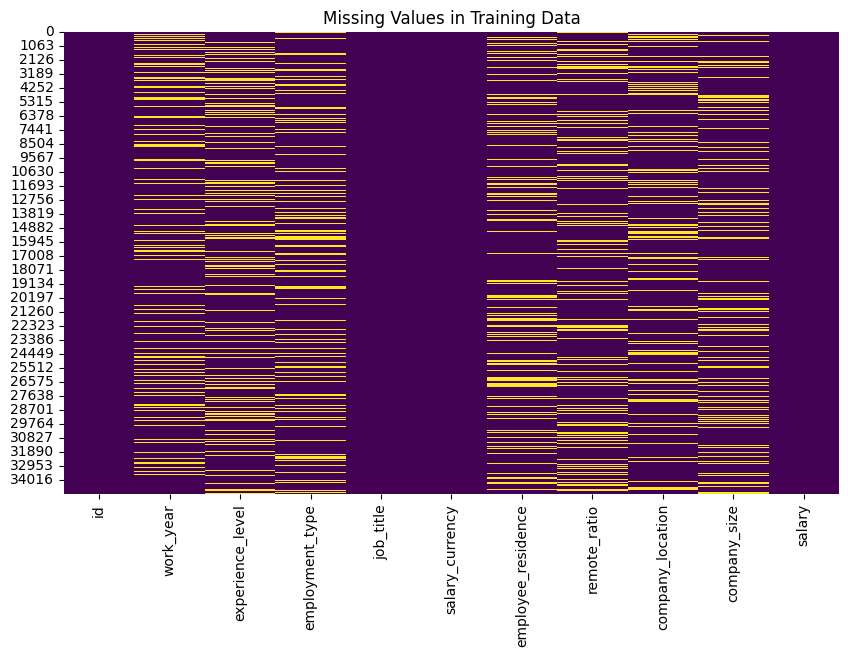

In [330]:
# 2. Heatmap Missing Values (Data Visualization)
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in Training Data')
plt.show()

Selanjutnya kita menerapkan visualisasi data dengan heatmap untuk melihat lokasi nilai yang hilang pada setiap data. Kotak kuning pada visualisasi ini menunjukkan missing values (NaN) pada data, semakin tebal warna kuning maka semakin banyak missing valuesnya.

Dapat disimpulkan bahwa data id, salary, job_title, dan salary_currency tidak memiliki missing values karena berwarna ungu tanpa kotak kuning. Sedangkan data lainnya memiliki banyak missing values yang tersebar tanpa pola. Data dengan missing values terbanyak adalah remote_ratio.

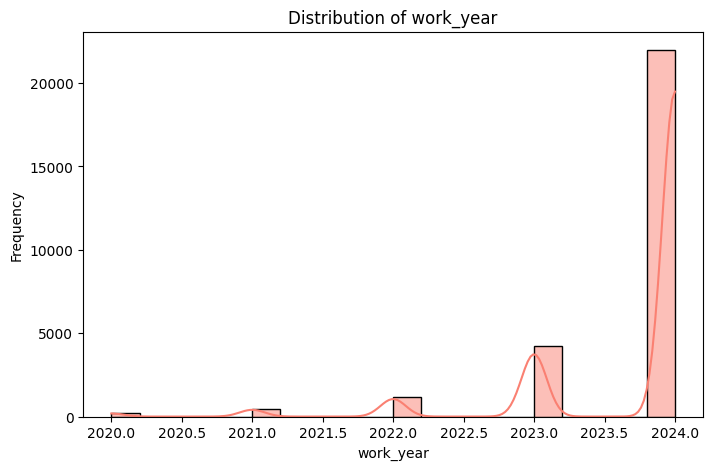

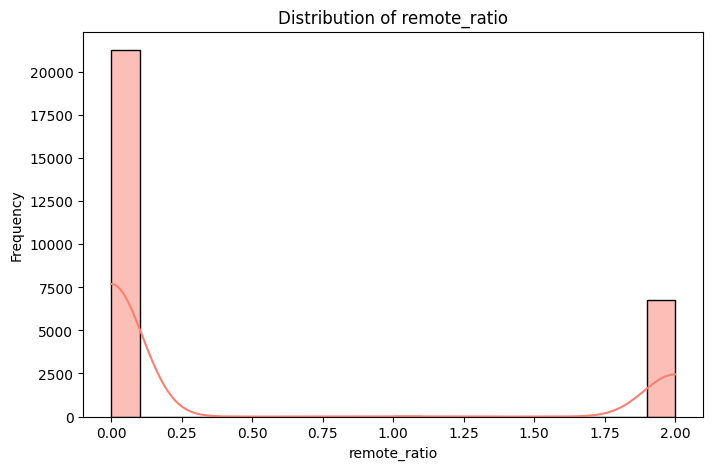

In [331]:
# 3. Distribusi Fitur Numerik (Data Visualization)
numerical_features = ['work_year', 'remote_ratio']
for feature in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.histplot(train_df[feature], kde=True, color='salmon', bins=20)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

Visualisasi kali ini berfokus pada distribusi fitur numerik melalui data work_year dan remote_ratio. Data work_year digunakan untuk menentukan tren salary dari waktu ke waktu, sedangkan remote_ratio untuk memprediksi hubungannya jarak lokasi tempat kerja (company_location & employee_residence) dengan salary.

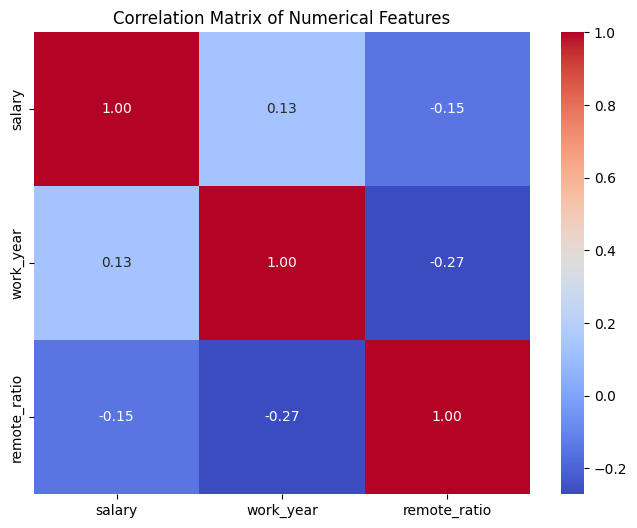

In [332]:
# 4. Analisis Korelasi Antar Fitur Numerik (Data Visualization)
plt.figure(figsize=(8, 6))
correlation_matrix = train_df[['salary', 'work_year', 'remote_ratio']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

Tujuan dari visualisasi ini adalah untuk mengukur sebuah hubungan antar dataset. Pada tahap ini visualisasi dengan Correlation Matrix digunakan untuk menunjukkan hubungan korelasi antar fitur numerik dalam data salary, work_year, dan remote_ratio. Hubungan ini diukur dengan Pearson Correlation Coefficient yang memiliki nilai antara -1 dan 1. Nilai ini nanti akan dikategorikan menjadi 4, yaitu positif sempurna (1.00)(Merah Tua), positif lemah (<1.00)(Merah Terang), negatif sempurna (-1.00)(Biru Tua), dan negatif lemah (-1.00 < x < 1.00)(Biru Terang).

Contohnya adalah salary vs remote_ratio berada pada -0.15 (negatif lemah) yang menandakan adanya hubungan yang bertolak belakang, seperti semakin sering remote working berarti gajinya yang ditawarkan semakin rendah atau sebaliknya (ex: tidak ada biaya tambahan transportasi untuk bekerja).
Selain itu jika positif negatif, contohnya pada salary vs work_year yang berada pada 0.13, menandakan bahwa kedua dataset ini memiliki tren yang sama, jika salah satu meningkat semuanya juga meningkat walau tidak signifikan dan sebaliknya (ex: inflasi).

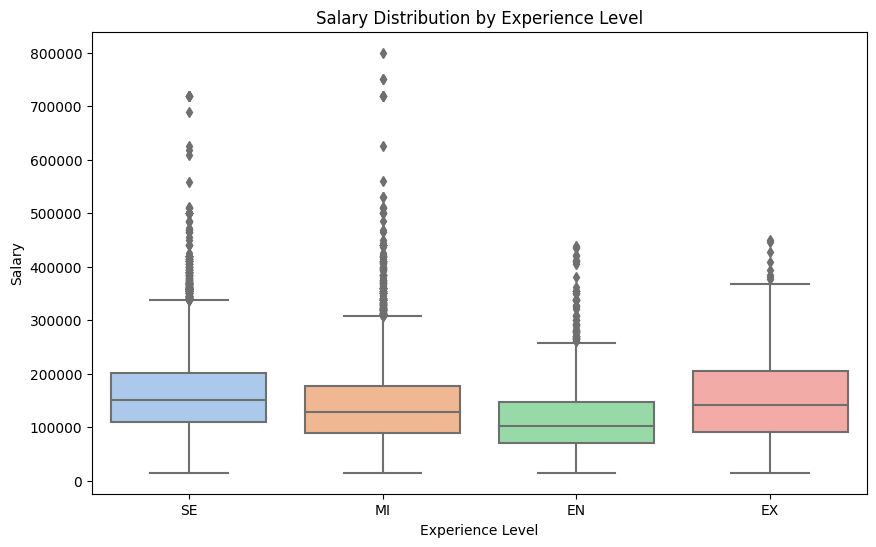

In [333]:
# 5. Distribusi Salary Berdasarkan Experience Level (Data Visualization)
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df, x='experience_level', y='salary', palette='pastel')
plt.title('Salary Distribution by Experience Level')
plt.xlabel('Experience Level')
plt.ylabel('Salary')
plt.show()

Visualisasi ini menunjukkan hubungan antara experience level dengan salary melalui teknik Boxplot. Pada sumbu X terdapat dataset mengenai experience level (SE = Senior Engineer, MI = Mid-level Engineer, EN = Entry-level Engineer, EX = Expert/Executive level), sedangkan sumbu y mengenai data salary terendah hingga tertinggi.

Pada teknik Boxplot ini, kotak (Box berwarna) menggambarkan rentang interquartile Range (IQR), antara Q1 dan Q3. Titik-titik di luar kotak menggambarkan outlier. Semakin tinggi titik-titik di luar kotak, maka outliers semakin tinggi. Lalu garis diantara kotak tanpat titk-titik (outlier) adalah nilai yang dianggap normal(Rentang Whiskers).




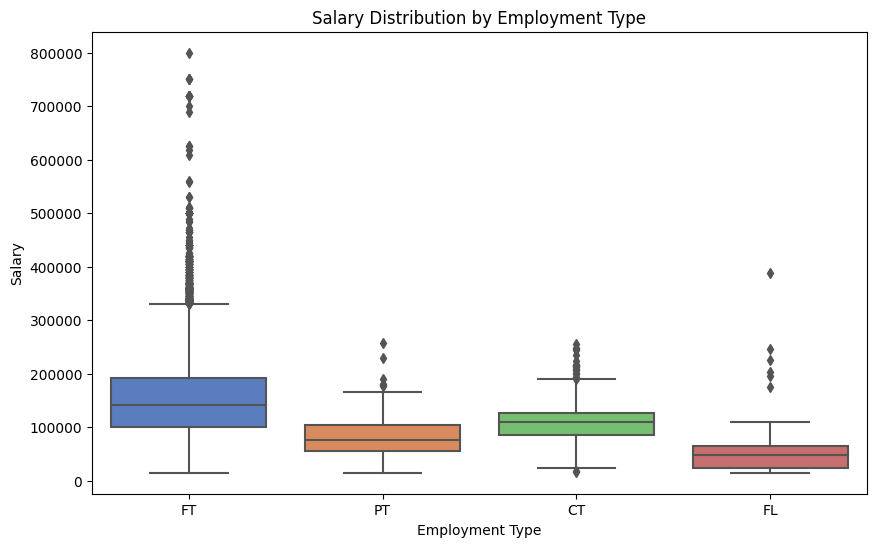

In [334]:
# 6. Distribusi Salary Berdasarkan Employment Type (Data Visualization)
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df, x='employment_type', y='salary', palette='muted')
plt.title('Salary Distribution by Employment Type')
plt.xlabel('Employment Type')
plt.ylabel('Salary')
plt.show()


Visualisasi ini menunjukkan hubungan antara employment type dengan salary melalui teknik Boxplot. Pada sumbu X terdapat dataset mengenai experience level (FT = Full Time, PT = Part Time, CT = Contract-based, FL = (Freelance), sedangkan sumbu y mengenai data salary terendah hingga tertinggi.

Dari visualisasi diatas, dapat disimpulkan bahwa FT memiliki median gaji tertinggi dibandingkan tipe pekerjaan lain, lalu diikuti CT, FL, dan yang terendah adalah PT. FT memiliki IQR paling lebar yang ditandakan dengan gambar kotak terbesar, yang menunjukkan memiliki variasi gaji yang tinggi.

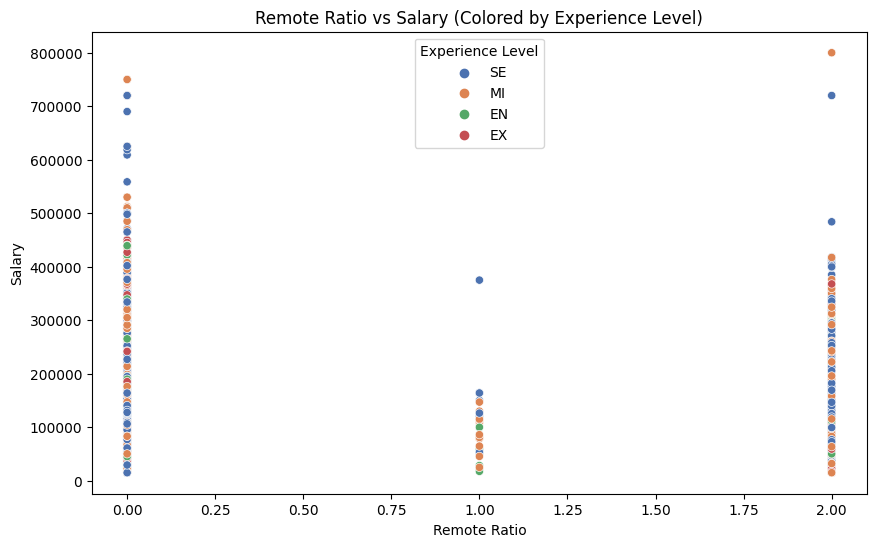

In [335]:
# 7. Scatter Plot: Remote Ratio vs Salary (Data Visualization)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_df, x='remote_ratio', y='salary', hue='experience_level', palette='deep')
plt.title('Remote Ratio vs Salary (Colored by Experience Level)')
plt.xlabel('Remote Ratio')
plt.ylabel('Salary')
plt.legend(title='Experience Level')
plt.show()

Visualisasi ini menggunakan scatterplot untuk menunjukkan hubungan antara remote ratio vs salary. Sumbu X menunjukkan remote ratio dengan kategori 0.0 (Full on site), 1.0 (Hybrid), 2.0 (fully remote).

Dapat dilihat bahwa sebagian besar data (titik-titik) berada di remote ratio 0.0 yang berarti pekerjaan banyak dilakukan sepenuhnya di kantor/full on site dengan salary yang paling bervariasi, berada di rentang (100,000 - 500,000 dolar). Lalu yang kedua adalah fully remote dengan munculnya outlier salary tertinggi dan yang terakhir adalah hybrid dengan gaji berada di rentang sedang hingga menengah (100,000 - 200,000 dollar).

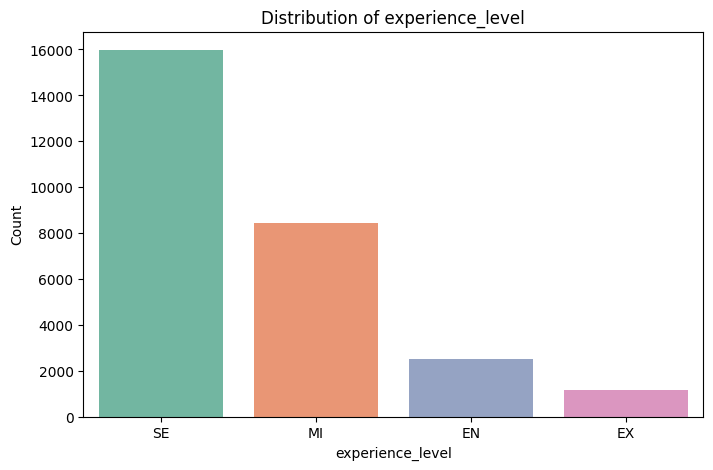

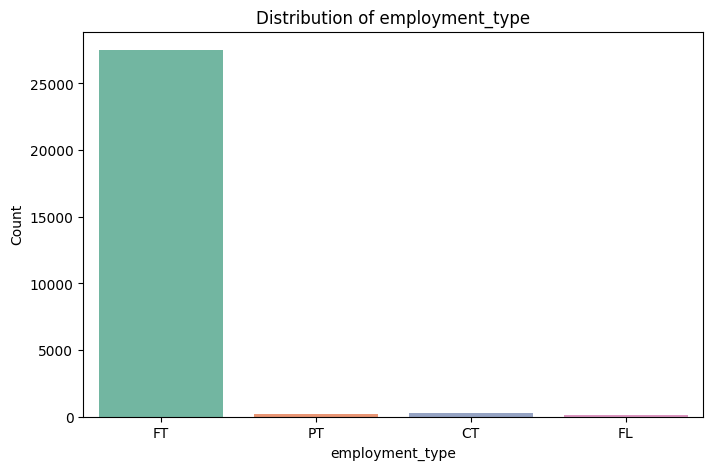

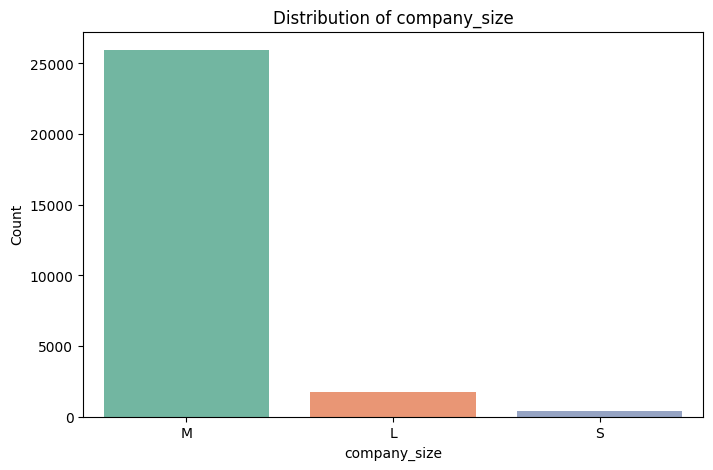

In [336]:
# 8. Distribusi Categorical Features (Data Visualization)
categorical_features = ['experience_level', 'employment_type', 'company_size']
for feature in categorical_features:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=train_df, x=feature, palette='Set2')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

Visualisasi yang terakhir terdiri dari tiga bar plot yang menunjukkan distribusi data untuk variabel experience_level, employment_type, dan company_size.

Bar plot pertama (Experience Level) menujukkan bahwa SE adalah mayoritas pengalaman kerja yang ada didalam dataset, dengan jumlah kurang lebih 16,000 individu. Selanjutnya adalah MI (9,000), EN (4,000), dan EX (2,000). Kesimpulannya adalah pengalaman kerja pada dataset ini lebih condong ke profesional berpengalaman.

Bar plot kedua (Employment Type) menunjukkan bahwa FT mendominasi dataset (25,000), berarti mayoritas individu bekerja full time. Urutan kedua adalah CT, sedangkan PT dan FL memiliki kategori terkecil.

Bar plot ketiga (Company Size) menunjukkan bahwa ukuran perusahaan menengah/medium (M) adalah yang terbanyak pada dataset, yaitu sebanyak (25,000), lalu diikuti perusahaan besar/large (L) sebanyak (3,000), dan yang terakhir adalah perusahaan kecil sebanyak (1,000). Sehingga dapat disimpulkan bahwa distribusi dataset ini sangat berfokus pada perusahaan skala menengah (M).

Tujuannya mengetahui distribusi ini adalah untuk Menentukan apakah distribusi data kategori seimbang atau tidak. Jika tidak, maka kita dapat menentukan teknik lanjutan pada data preprocessing, seperti meggabungkan kategori data yang sangat sedikit ke kategori data yang lain agar menjadi merata atau menggunakan teknik lainnya, sehingga ketidakseimbangan kategori tidak mempengaruhi performa model.

## **C. Data Preprocessing**

Penanganan missing values, menggabungkan features, menambahkan new features.

In [337]:
# Cek apakah ada missing values (NaN) pada dataset
print("Missing Values in Train Dataset:") #Train
print(train_df.isnull().sum())

print("\nMissing Values in Test Dataset:") #Test
print(test_df.isnull().sum())

Missing Values in Train Dataset:
id                       0
work_year             7016
experience_level      7016
employment_type       7016
job_title                0
salary_currency          0
employee_residence    7016
remote_ratio          7016
company_location      7016
company_size          7016
salary                   0
dtype: int64

Missing Values in Test Dataset:
id                    0
work_year             0
experience_level      0
employment_type       0
job_title             0
salary_currency       0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64


In [338]:
# 1. Handle Missing Values
categorical_cols = ['experience_level', 'employment_type', 'employee_residence', 'company_location', 'company_size']
numerical_cols = ['work_year', 'remote_ratio']
train_df[categorical_cols] = train_df[categorical_cols].fillna('Unknown')
test_df[categorical_cols] = test_df[categorical_cols].fillna('Unknown')
train_df[numerical_cols] = train_df[numerical_cols].fillna(train_df[numerical_cols].median())
test_df[numerical_cols] = test_df[numerical_cols].fillna(train_df[numerical_cols].median())

Pada pengecekan missing values dapat ditemukan bahwa ada 7016 missing values pada data work_year, experience_level, dan lain-lain. Oleh karena itu kita harus mengganti nilai missing values tersebut dengan median agar prediksi model berjalan maksimal dan sejalan dengan visualisasi data yang telah dilakukan. Penggantian missing values ini juga bertujuan untuk menghindari data hilang.

In [339]:
# Check for missing values after handle
print("Missing Values in Train Dataset:")
print(train_df.isnull().sum())


print("\nMissing Values in Test Dataset:")
print(test_df.isnull().sum())


Missing Values in Train Dataset:
id                    0
work_year             0
experience_level      0
employment_type       0
job_title             0
salary_currency       0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
salary                0
dtype: int64

Missing Values in Test Dataset:
id                    0
work_year             0
experience_level      0
employment_type       0
job_title             0
salary_currency       0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64


In [340]:
#Refine Features (Penambahan Features Baru)
def refine_features(df):
    job_title_map = {
        "Data Analyst": "Data Role",
        "Data Scientist": "Data Role",
        "AI Engineer": "AI Role",
    }
    df['grouped_job_title'] = df['job_title'].map(job_title_map).fillna(df['job_title'])
    experience_level_map = {'Junior': 1, 'Mid': 2, 'Senior': 3, 'Expert': 4}
    df['seniority_level'] = df['experience_level'].map(experience_level_map).fillna(0)
    df['same_country'] = (df['employee_residence'] == df['company_location']).astype(int)
    df['job_residence_interaction'] = df['job_title'] + '_' + df['employee_residence']
    df['title_location_interaction'] = df['job_title'] + '_' + df['company_location']
    return df

train_df = refine_features(train_df)
test_df = refine_features(test_df)

In [341]:
# Display the first few rows of the grouped data
grouped_rows = train_df[train_df['grouped_job_title'] != train_df['job_title']]

print("Rows with Grouped Job Titles:")
print(grouped_rows[['job_title', 'grouped_job_title']].head())


Rows with Grouped Job Titles:
         job_title grouped_job_title
8   Data Scientist         Data Role
11  Data Scientist         Data Role
12  Data Scientist         Data Role
17    Data Analyst         Data Role
22    Data Analyst         Data Role


***# 2. Grouping Job***

Tujuan dari grouping ini adalah untuk Mengurangi dimensi kategori pada job_title agar lebih sederhana tanpa kehilangan informasi penting dan
membantu model memahami kelompok pekerjaan tanpa harus menangani terlalu banyak kategori unik.


**# 3. Seniority Level**

Fitur experience_level (kategori) diubah menjadi nilai numerik sesuai urutan senioritas, yaitu dengan Nilai Junior menjadi 1, Mid menjadi 2, dan seterusnya. Tujuannya untuk Memberikan nilai yang lebih bermakna untuk experience_level, sehingga model memahami urutan atau prioritas senioritas.

**# 4. Same Country**

Pembuatan fitur baru dengan pengelompokkan karyawan dan letak perusahaan yang berada di negara yang sama. Jika lokasi sama, nilainya adalah 1, jika tidak, nilainya adalah 0. Tujuannya untuk menangkap pola geografis yang mungkin memengaruhi gaji, seperti perbedaan biaya hidup di negara yang berbeda.

Note: Fitur ini tidak meningkatkan kompleksitas dataset karena hanya berupa nilai biner (1/0).


**# 5. job_residence_interaction dan title_location_interaction**

Membuat fitur baru dengan menggabungkan job_title dengan employee_residence dan company_location.
Contoh:
Jika job_title adalah Data Analyst dan employee_residence adalah US, maka fitur job_residence_interaction akan menjadi Data Analyst_US.

Tujuannya adalah untuk Menangkap interaksi spesifik antara pekerjaan dan lokasi, yang mungkin memiliki pengaruh besar terhadap gaji.
Contoh: Gaji seorang Data Scientist di AS mungkin jauh lebih tinggi dibandingkan di negara lain.

In [342]:
# 6. Target Encoding (Encoding)
encoder = TargetEncoder()
target_encoded_cols = ['grouped_job_title', 'job_residence_interaction', 'title_location_interaction']

for col in target_encoded_cols:
    train_df[col] = encoder.fit_transform(train_df[col], train_df['salary'])
    test_df[col] = encoder.transform(test_df[col])


Target Encoding disini berfungsi untuk mengganti nilai kategori dengan rata-rata nilai target (salary) untuk setiap kategori.
Contoh: Jika grouped_job_title adalah Data Role dan rata-rata salary untuk Data Role adalah 80.000, maka kategori Data Role akan diganti dengan angka 80.000.

Keuntungan Target Encoding:
1. Efisien untuk High Cardinality:
Lebih cocok dibandingkan One-Hot Encoding jika kolom memiliki banyak kategori unik (high cardinality).
Tidak meningkatkan dimensi dataset seperti One-Hot Encoding.
2. Menangkap Informasi Langsung:
Encoding ini menyimpan hubungan antara kategori dan target variable, membantu model memahami pola lebih baik.
3. Kompatibilitas dengan Model:
Ideal untuk algoritma seperti LightGBM yang dapat memanfaatkan encoding numerik langsung.

In [343]:
# 7. Encode Categorical Features Using OrdinalEncoder (Encoding)
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
all_categorical_cols = categorical_cols + ['job_title']
train_df[all_categorical_cols] = ordinal_encoder.fit_transform(train_df[all_categorical_cols].astype(str))
test_df[all_categorical_cols] = ordinal_encoder.transform(test_df[all_categorical_cols].astype(str))

Ordinal Encoding berfungsi mengganti kategori dengan nilai numerik berdasarkan urutan tertentu.
Contoh: Jika kolom experience_level memiliki kategori [Junior, Mid, Senior, Expert], mereka dapat dikodekan menjadi [0, 1, 2, 3].


Note: Semua kolom kategori lainnya yang tidak di-target encode (experience_level, employment_type, dll.) diubah menjadu numerik menggunakan OrdinalEncoder.

Keuntungan Ordinal Encoding:
Sederhana:
Encoding ini langsung mengubah kategori menjadi numerik tanpa menambah dimensi dataset.
Kompatibilitas dengan Model:
Model berbasis tree (seperti LightGBM) dapat menangani nilai ordinal dengan baik karena tidak mengasumsikan hubungan linier antar kategori.
Efisien untuk Kolom dengan Cardinality Rendah:
Ideal untuk kategori dengan jumlah unik sedikit (low cardinality), seperti experience_level.

In [344]:
# Cek apakah semua datatype sudah berubah menjadi numerical
print("Train Dataset Info:") 
print(train_df.info())

print("\nTest Dataset Info:")
print(test_df.info())


Train Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35078 entries, 0 to 35077
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          35078 non-null  int64  
 1   work_year                   35078 non-null  float64
 2   experience_level            35078 non-null  float64
 3   employment_type             35078 non-null  float64
 4   job_title                   35078 non-null  float64
 5   salary_currency             35078 non-null  object 
 6   employee_residence          35078 non-null  float64
 7   remote_ratio                35078 non-null  float64
 8   company_location            35078 non-null  float64
 9   company_size                35078 non-null  float64
 10  salary                      35078 non-null  int64  
 11  grouped_job_title           35078 non-null  float64
 12  seniority_level             35078 non-null  float64
 13  same_countr

In [345]:
# 8. Prepare Features and Target
X = train_df.drop(['id', 'salary', 'salary_currency'], axis=1)
y = train_df['salary']


Kode ini berfungsi untuk memisahkan fitur dan target. Fitur adalah input yang digunakan oleh model untuk memprediksi nilai target, sedangkan Target adalah nilai yang ingin diprediksi oleh model.Variabel y/target inilah yang akan digunakan oleh model untuk belajar (training) dan evaluasi.

Fitur (X)   : Semua kolom dalam dataset training (train_df) kecuali id, salary, dan salary_currency.

Target (y) : Salary.

## **D. Modelling**

Saya menggunakan LightGBM karena target yang ingin dicapai adalah prediksi salary, sehingga pendekatan supervised learning sangat cocok untuk tugas ini. LightGBM dipilih karena model ini berbasis decision tree, yang sangat baik dalam mempelajari hubungan antara fitur-fitur dalam data untuk memprediksi nilai target. Selain itu, LightGBM dikenal sangat efisien dalam hal waktu komputasi dan konsumsi memori, sehingga memungkinkan pelatihan model pada dataset yang besar dengan cepat. 

Saya juga menambahkan metode K-Fold Cross Validation agar data dapat dibagi menjadi beberapa fold, sehingga setiap bagian data akan mendapatkan giliran sebagai data validasi, sehingga performa model tidak hanya diuji pada subset data tertentu, tetapi pada seluruh dataset secara merata. 

In [346]:
# 1. LightGBM Hyperparameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'min_data_in_leaf': 20,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 42,
    'verbose': -1
}

Apa itu LightGBM?
LightGBM (Light Gradient Boosting Machine) adalah framework gradient boosting yang dioptimalkan untuk kecepatan dan efisiensi.
Cocok untuk data tabular dengan ukuran besar, dan secara bawaan mendukung fitur kategori (categorical features) karena Tidak perlu secara eksplisit mengubah kategori menjadi one-hot encoded.

In [347]:
# 2. Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rmse = []
cv_r2 = []

print("Starting k-Fold Cross-Validation...")
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"Fold {fold + 1}")
    
    # Split Data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # LightGBM Dataset
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_eval = lgb.Dataset(X_val, label=y_val, reference=lgb_train)
    
    # Train Model
    gbm = lgb.train(
        params=params,
        train_set=lgb_train,
        valid_sets=[lgb_train, lgb_eval],
        valid_names=['training', 'validation'],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)]
    )

  # 3. Evaluate Model (Prediction Result)
    y_val_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
    rmse = mean_squared_error(y_val, y_val_pred, squared=False)
    r2 = r2_score(y_val, y_val_pred)
    
    print(f"Fold {fold + 1} RMSE: {rmse}")
    print(f"Fold {fold + 1} R^2: {r2}")
    
    cv_rmse.append(rmse)
    cv_r2.append(r2)

print("\nCross-Validation Results:")
print(f"Mean RMSE: {np.mean(cv_rmse)}")
print(f"Mean R^2: {np.mean(cv_r2)}")

Starting k-Fold Cross-Validation...
Fold 1
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 59690.3	validation's rmse: 62075.1
Early stopping, best iteration is:
[125]	training's rmse: 59467.4	validation's rmse: 62023.7
Fold 1 RMSE: 62023.694051355444
Fold 1 R^2: 0.2944924643247834
Fold 2
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 60088.5	validation's rmse: 60486.9
Early stopping, best iteration is:
[132]	training's rmse: 59830.9	validation's rmse: 60455.9
Fold 2 RMSE: 60455.90166411725
Fold 2 R^2: 0.3068606825519866
Fold 3
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 60149.8	validation's rmse: 60155.9
Early stopping, best iteration is:
[138]	training's rmse: 59785.3	validation's rmse: 60076
Fold 3 RMSE: 60076.009247573835
Fold 3 R^2: 0.30302675676599
Fold 4
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 59977.6	validation's rmse: 60990

**# 2. Cross-Validation**

K-Fold Cross-Validation membagi dataset menjadi K bagian (folds). Pada setiap iterasi, satu fold digunakan untuk validasi, sementara sisanya digunakan untuk pelatihan.

5-Fold Cross-Validation digunakan untuk membagi dataset menjadi 5 bagian. Melatih model 5 kali, dengan masing-masing fold menjadi data validasi sekali.

Tujuan:

*Menghindari Overfitting:
Membantu mengevaluasi performa model pada data yang tidak terlihat (unseen data).

*Mengukur Generalisasi:
Memberikan gambaran akurasi model yang lebih konsisten dibandingkan split tunggal.

LightGBM Dataset:
lgb.Dataset mengonversi dataset menjadi format yang dioptimalkan untuk LightGBM.

Early Stopping:
early_stopping(stopping_rounds=50) menghentikan pelatihan jika RMSE tidak membaik selama 50 iterasi berturut-turut, menghindari pemborosan waktu pelatihan dan overfitting.

**# 3. Evaluate Model (Prediction Result)**

1. RMSE (Root Mean Squared Error):
Mengukur rata-rata kesalahan prediksi. Nilai yang lebih kecil menunjukkan model lebih akurat.
2. R² (Coefficient of Determination):
Mengukur seberapa baik model menjelaskan variabilitas data target. Nilai mendekati 1 menunjukkan performa yang baik.

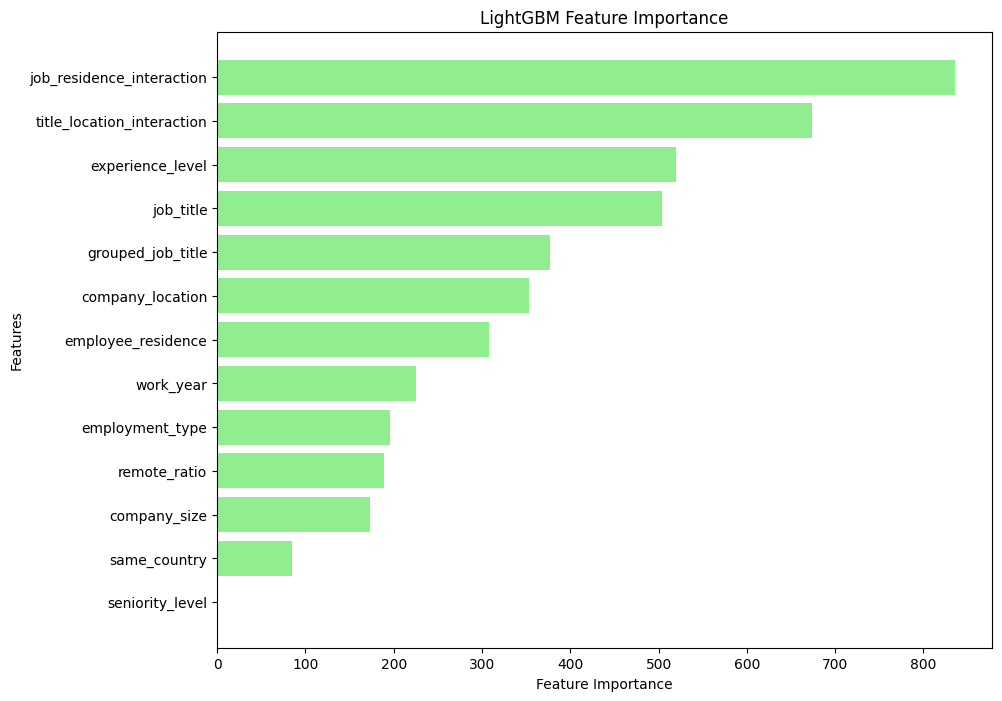

In [348]:
# 4. Feature Importance (Data Visualization)
lgb_feature_importance = pd.DataFrame({'Feature': X.columns, 
                                       'Importance': gbm.feature_importance()}).sort_values(by='Importance', ascending=True)

# Visualization
plt.figure(figsize=(10, 8))
plt.barh(lgb_feature_importance['Feature'], lgb_feature_importance['Importance'], color='lightgreen')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('LightGBM Feature Importance')
plt.show()


Dari visualisasi Feature Importance menggunakan LightGBM, terlihat bahwa fitur job_residence_interaction memiliki pengaruh terbesar dalam menentukan prediksi salary. Ini menunjukkan bahwa interaksi antara pekerjaan dan lokasi tempat tinggal karyawan memberikan informasi penting terkait gaji yang ditawarkan. Fitur penting lainnya memiliki pengaruh yang lebih rendah. Analisis ini membantu memahami bagaimana masing-masing fitur memengaruhi model dalam memprediksi salary.

## **E. File Submission**

Mempersiapkan data testing untuk prediksi, menghasilkan prediksi salary untuk data testing menggunakan model yang telah dilatih, dan menyusun file submission sesuai dengan format.

In [349]:
# Prepare Test Data and Predict
X_test = test_df.drop(['id', 'salary_currency'], axis=1)
test_df['salary'] = gbm.predict(X_test, num_iteration=gbm.best_iteration)

# Prepare Submission
submission_df = test_df[['id', 'salary']]
submission_df.to_csv('submission_lgb.csv', index=False)
print("Submission file saved as 'submission_lgb.csv'")

Submission file saved as 'submission_lgb.csv'


## **Conclusion**

Notebook ini berhasil memanfaatkan pendekatan supervised learning menggunakan LightGBM untuk prediksi salary. Dengan proses EDA, feature engineering, dan evaluasi menggunakan K-Fold Cross Validation, model mampu mempelajari hubungan antar fitur cukup baik. Sayangnya hasil yang didapatkan kurang akurat sehingga masih diperlukan penyesuaian dan pelatihan lebih lanjut. Pada hasil submisi kaggle, code ini mendapatkan score akhir 60570.92679.